In [28]:
%load_ext autoreload
%autoreload 2

In [53]:
from domino.slices import collect_settings
from domino.slices.celeba import CelebASliceBuilder
from domino.evaluate import run_sdm, score_sdms, run_sdms
from domino.train import train_settings
import numpy as np
import pandas as pd
import terra
import seaborn as sns
from domino.emb.clip import embed_phrases
import matplotlib.pyplot as plt 

In [54]:
run_ids = [37943, 37491, 36681]
score_df = pd.concat([score_sdms.out(run_id).load() for run_id in run_ids])
score_df = score_df.fillna(0)

In [55]:
score_df

,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,recall,precision,target_name,run_sdm_run_id,emb_group,alpha,sdm_class,slice_name
0,0,0,0.243088,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,vehicle.n.01,37550,clip,0.03,domino.sdm.confusion.ConfusionSDM,tractor.n.01
1,1,0,0.243088,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,vehicle.n.01,37550,clip,0.03,domino.sdm.confusion.ConfusionSDM,tractor.n.01
2,2,0,0.902901,0.5,0.44,0.25,0.171429,0.238095,0.352381,0.561905,0.113900,vehicle.n.01,37550,clip,0.03,domino.sdm.confusion.ConfusionSDM,tractor.n.01
3,3,0,0.610924,0.0,0.00,0.00,0.000000,0.000000,0.009524,0.438095,0.019024,vehicle.n.01,37550,clip,0.03,domino.sdm.confusion.ConfusionSDM,tractor.n.01
4,4,0,0.500000,0.0,0.04,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,vehicle.n.01,37550,clip,0.03,domino.sdm.confusion.ConfusionSDM,tractor.n.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35455,0,0,0.899866,0.0,0.00,0.08,0.047619,0.126984,0.222222,1.000000,0.033564,timepiece.n.01,36675,clip,0.03,domino.sdm.gmm.MixtureModelSDM,watch.n.01
35456,1,0,0.087466,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,timepiece.n.01,36675,clip,0.03,domino.sdm.gmm.MixtureModelSDM,watch.n.01
35457,2,0,0.105334,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,timepiece.n.01,36675,clip,0.03,domino.sdm.gmm.MixtureModelSDM,watch.n.01
35458,3,0,0.500000,0.0,0.08,0.02,0.000000,0.000000,0.000000,0.000000,0.000000,timepiece.n.01,36675,clip,0.03,domino.sdm.gmm.MixtureModelSDM,watch.n.01


In [56]:
plot_df = score_df.iloc[
    score_df.reset_index()
    .groupby(["target_name", "slice_name", "slice_idx", "emb_group", "alpha", "sdm_class"])["auroc"]
    .idxmax()
    .astype(int)
].copy()


<AxesSubplot:xlabel='precision_at_10', ylabel='emb_group'>

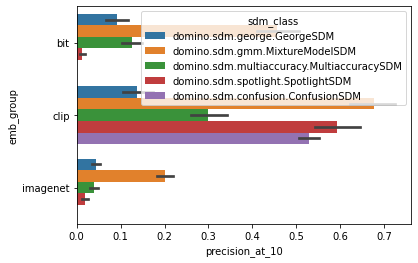

In [57]:
sns.barplot(data=plot_df, x="precision_at_10", y="emb_group", hue="sdm_class")

<AxesSubplot:xlabel='success', ylabel='emb_group'>

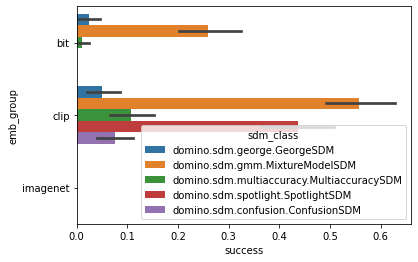

In [61]:
plot_df["success"] = (plot_df["precision_at_10"] > 0.7)
sns.despine()

sns.barplot(data=plot_df,  x="success", y="emb_group", hue="sdm_class")


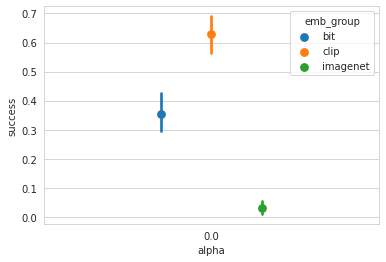

In [139]:
plot_df["success"] = (plot_df["auroc"] > 0.85) & (plot_df["precision_at_10"] > 0.5)
sns.set_style("whitegrid")
sns.despine()
#plot_df["alpha"] = plot_df["alpha"].round(1)
sns.pointplot(
    data=plot_df, hue="emb_group", y="success", x="alpha", linestyles="", dodge=0.3,  
)
plt.savefig("figures/09-22_alpha_v_success.pdf")


In [56]:
inp = run_sdm.inp(run_id=17412, load=True)
data_dp, emb_dp = inp["data_dp"], inp["emb_dp"]

data_dp = data_dp.lz[data_dp["split"].isin(["valid", "test"])].merge(
    emb_dp[["image_id", "emb"]], on="image_id"
)
slice_idx = 0
inp["slice_names"][slice_idx]

'wearing_necklace=0_blond_hair=1'

In [57]:
from domino.sdm import MixtureModelSDM, SpotlightSDM
sdm = MixtureModelSDM(
    n_slices=5, 
    n_clusters=5, 
    weight_y_log_likelihood=10, 
    init_params="error",
    emb="emb",
    pca_components=128 
)

sdm.fit(data_dp.lz[data_dp["split"] == "valid"])
dp = sdm.transform(data_dp.lz[data_dp["split"] == "test"])

in fit


  8%|▊         | 8/100 [00:00<00:01, 86.26it/s]


In [58]:
from domino.metrics import compute_sdm_metrics

metrics_df = compute_sdm_metrics(dp)
metrics_df[metrics_df["slice_idx"] == slice_idx].sort_values(
    by="auroc", ascending=False
)


,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,recall,precision
0,0,0,0.848332,0.9,0.8,0.44,0.123506,0.175299,0.235060,0.549801,0.186486
1,1,0,0.778580,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0,0.587992,0.0,0.0,0.01,0.000000,0.003984,0.015936,0.195219,0.053319
4,4,0,0.397326,0.0,0.0,0.01,0.000000,0.003984,0.003984,0.159363,0.017197
2,2,0,0.392655,0.0,0.0,0.01,0.000000,0.003984,0.011952,0.095618,0.018141


In [59]:
pred_slice_idx = 0
words_dp = embed_phrases.out().load()
words_dp = words_dp.lz[:10_000]
expl_dp = sdm.explain(
    words_dp=words_dp,
    data_dp=dp
)
expl_dp.lz[(-expl_dp["pred_slices"])[:, pred_slice_idx].argsort()[:10]]

,word (PandasSeriesColumn),pred_slices (NumpyArrayColumn)
0,a photo of a man with blackish hair.,"np.ndarray(shape=(5,))"
1,a photo of a man with brown hair.,"np.ndarray(shape=(5,))"
2,a photo of a guy with dark hair.,"np.ndarray(shape=(5,))"
3,a photo of a man looking tired.,"np.ndarray(shape=(5,))"
4,a photo of a man with brownish hair.,"np.ndarray(shape=(5,))"
5,a photo of a man looking depressed.,"np.ndarray(shape=(5,))"
6,a photo of a man with unfinished business.,"np.ndarray(shape=(5,))"
7,a photo of a guy with blackish hair.,"np.ndarray(shape=(5,))"
8,a photo of a stoic man,"np.ndarray(shape=(5,))"
9,a photo of a man pondering.,"np.ndarray(shape=(5,))"


In [93]:
#attribute = "mustache"

words_dp = embed_phrases.out().load()
words_dp = words_dp[:10_000]

pred_slice_idx = 0
words_dp = words_dp.view()
pred_slice = dp["pred_slices"][:, pred_slice_idx]
slice_proto = dp.lz[pred_slice.argsort()[-10:]]["emb"].mean(axis=0)
#slice_proto = dp["emb"][dp[attribute] == 1].mean(axis=0)
#slice_proto = dp.lz[dp["probs"].argsort()[-25:]]["emb"].mean(axis=0)


ref_proto = dp["emb"][dp["target"] == 0].data.mean(axis=0)

words_dp["pred_slices"] = np.dot(
    words_dp["emb"].data, (slice_proto - ref_proto).T
)
expl_dp = words_dp[["word", "pred_slices"]]
expl_dp.lz[(-expl_dp["pred_slices"]).argsort()[0:5]]

,word (PandasSeriesColumn),pred_slices (NumpyArrayColumn)
0,a photo of a woman with blonde hair.,6.089844
1,a photo of a girl with blonde hair.,5.761719
2,a photo of a blonde woman,5.574219
3,a photo of a blonde girl,5.449219
4,a photo of a woman golden haired.,4.707031


,image (ImageColumn),target (NumpyArrayColumn),correlate (NumpyArrayColumn)
0,,0,1
1,,0,1
2,,0,1
3,,0,1
4,,0,1
5,,0,1
6,,0,1
7,,0,1
8,,0,1
9,,0,1

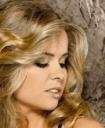
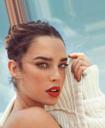
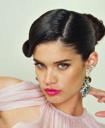
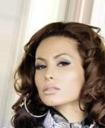
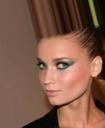
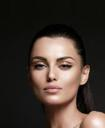
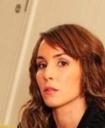
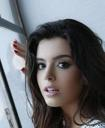
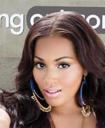
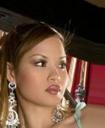

In [32]:

dp.lz[dp["pred_slices"].data[:, pred_slice_idx].argsort()[-10:]][["image", "target", "correlate"]]

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plot_df = pd.DataFrame(
    {"probs": dp["probs"], "slice": dp["slices"][:, slice_idx], "target": dp["target"]}
)
sns.histplot(
    data=plot_df[plot_df["target"] == 0],
    x="probs",
    hue="slice",
    stat="count",
    common_norm=not False,
    binwidth=0.1,
)
plt.yscale("log")


ValueError: Data must be 1-dimensional

In [6]:
from domino.train import score_settings, train_settings, score_model, train_model

In [82]:
attribute = "mustache"

words_dp = embed_phrases.out().load()
words_dp = words_dp.lz[:10_000]

pred_slice_idx = 0
words_dp = words_dp.view()
slice_proto = (
    np.dot(dp["pred_slices"].T, dp["emb"])
    / dp["pred_slices"].sum(axis=0, keepdims=True).T
)
slice_proto = dp["emb"][dp[attribute] == 1].mean(axis=0)
#slice_proto = dp.lz[dp["probs"].argsort()[-25:]]["emb"].mean(axis=0)


ref_proto = dp["emb"][dp[attribute] == 0].data.mean(axis=0)

words_dp["pred_slices"] = np.dot(
    words_dp["emb"].data, (slice_proto - ref_proto).T
)
expl_dp = words_dp[["word", "pred_slices"]]
expl_dp.lz[(-expl_dp["pred_slices"]).argsort()[0:10]]

,word (PandasSeriesColumn),pred_slices (NumpyArrayColumn)
0,a photo of a man with mustaches.,4.753906
1,a photo of a man with mustache.,4.718750
2,a photo of a man with a mustache.,4.652344
3,a photo of a guy with mustache.,4.445312
4,a photo of a guy with mustaches.,4.421875
5,a photo of a man in blackness.,4.371094
6,a photo of a man with swagger.,4.277344
7,a photo of a guy with facial hair.,4.207031
8,a photo of a man of quality.,4.183594
9,a photo of a man to relate to.,4.125000


In [5]:
score_settings.out().load()["score_model_run_id"]

,(PandasSeriesColumn)
0,15006
1,15007
2,15008
3,15005
4,15009
5,15010
6,15011
7,15012
8,15014
9,15013


In [8]:
score_dp = score_model.out(15006).load()

In [18]:
from sklearn.metrics import roc_auc_score
mask = score_dp["target"] != score_dp["correlate"]
roc_auc_score(score_dp.lz[mask]["target"], score_dp.lz[mask]["probs"][:, 1])

0.26252927075972343

In [13]:
score_dp["probs"] = score_dp["output"].probabilities()

In [10]:
from domino.train import score_settings, synthetic_score_settings, score_model

In [5]:
type(synthetic_score_settings.out().load())

meerkat.datapanel.DataPanel

In [19]:
score_settings.out()[0].load()

,train_model_run_id (PandasSeriesColumn),setting_id (NumpyArrayColumn),corr (NumpyArrayColumn),correlate (PandasSeriesColumn),dataset (PandasSeriesColumn),n (NumpyArrayColumn),slice_category (PandasSeriesColumn),target (PandasSeriesColumn),index (PandasSeriesColumn),parent_run_id (PandasSeriesColumn),build_setting_run_id (PandasSeriesColumn),time_this_iter_s (PandasSeriesColumn),done (PandasSeriesColumn),timesteps_total (PandasSeriesColumn),episodes_total (PandasSeriesColumn),training_iteration (PandasSeriesColumn),experiment_id (PandasSeriesColumn),date (PandasSeriesColumn),timestamp (PandasSeriesColumn),time_total_s (PandasSeriesColumn),pid (PandasSeriesColumn),hostname (PandasSeriesColumn),node_ip (PandasSeriesColumn),time_since_restore (PandasSeriesColumn),timesteps_since_restore (PandasSeriesColumn),iterations_since_restore (PandasSeriesColumn),trial_id (PandasSeriesColumn),config/corr (PandasSeriesColumn),config/correlate (PandasSeriesColumn),config/dataset (PandasSeriesColumn),config/index (PandasSeriesColumn),config/n (PandasSeriesColumn),config/setting_id (PandasSeriesColumn),config/slice_category (PandasSeriesColumn),config/target (PandasSeriesColumn),logdir (PandasSeriesColumn),score_settings_run_id (PandasSeriesColumn),score_model_run_id (PandasSeriesColumn),synthetic_preds (PandasSeriesColumn)
0,14936,163,0.6,blond_hair,celeba,30000,correlation,wearing_necklace,0,14928,14930,1112.037066,False,NaN,NaN,1,8ef98aebaa294f1f8875ae337af348ea,2021-09-22_12-08-35,1632312515,1112.037066,198,run-script-nf5ts,10.92.1.25,1112.037066,0,1,36c4b_00000,0.6,blond_hair,celeba,163,30000,163,correlation,wearing_necklace,"/root/ray_results/_train_model_2021-09-22_11-49-59/_train_model_36c4b_00000_0_config={'corr': 0.6000000000000001, 'correlate': 'blond_hair', 'dataset': 'celeba', 'n': 30000, 'slice__2021-09-22_11-49-59",15044,15045,False
1,14933,139,0.8,eyeglasses,celeba,30000,correlation,wearing_hat,1,14928,14931,1116.230135,False,NaN,NaN,1,20a0c9441e584990983fc829547b6915,2021-09-22_12-08-39,1632312519,1116.230135,196,run-script-nf5ts,10.92.1.25,1116.230135,0,1,36c4b_00001,0.8,eyeglasses,celeba,139,30000,139,correlation,wearing_hat,"/root/ray_results/_train_model_2021-09-22_11-49-59/_train_model_36c4b_00001_1_config={'corr': 0.8, 'correlate': 'eyeglasses', 'dataset': 'celeba', 'n': 30000, 'slice_category': 'cor_2021-09-22_11-49-59",15044,15046,False


In [24]:
score_model.out(15045)[0].load()["split"].unique()

array(['train', 'valid'], dtype=object)

In [56]:
from domino.data.celeba import get_celeba_dp

In [96]:
sb = CelebASliceBuilder()
out = sb.build_rare_setting(
    data_dp=get_celeba_dp.out().load(),
    target_attrs=["wearing_earrings", "male", "blond_hair"],
    slice_attrs=["blond_hair"],
    slice_frac=0.01,
    target_frac=0.5,
    n=20_000
)

In [99]:
out["wearing_earrings"].mean()

0.1394

In [84]:
np.any(out == 1, axis=0).mean()

0.7881282730911802

In [73]:
 data_dp=get_celeba_dp.out().load()

In [85]:
target_attrs=["wearing_earrings", "male", "blond_hair"]

targets = np.array(
            [data_dp[attr] for attr in target_attrs]
)


In [100]:
train_settings.out()

NameError: name 'train_settings' is not defined

In [97]:
from domino.emb.clip import get_wiki_words
dp = get_wiki_words(top_k=10_000, eng_only=True).load()
(dp["word"] == "earrings").any()

task: get_wiki_words, run_id=16792


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


False

In [98]:
dp

,word (PandasSeriesColumn),frequency (PandasSeriesColumn),index (PandasSeriesColumn)
0,the,151983633.0,0
1,of,71874676.0,1
2,and,62210193.0,2
3,in,62004799.0,3
4,to,43364193.0,4
...,...,...,...
9995,het,5533.0,9995
9996,cleric,5531.0,9996
9997,unfavorable,5528.0,9997
9998,disperse,5528.0,9998


In [104]:
"blond" in dp["word"]

False

In [5]:
import nltk
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
from nltk.corpus import wordnet as wn
nl

In [71]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("A portrait of a person", max_length=7, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'A portrait of a person who died'},
 {'generated_text': "A portrait of a person's head"},
 {'generated_text': 'A portrait of a person holding down'},
 {'generated_text': 'A portrait of a person who will'},
 {'generated_text': 'A portrait of a person wearing long'}]

In [17]:
hypernyms = []
for hypernym in synset.closure(lambda s: s.hypernyms()):
    hypernyms.append(
        {
            "synset": synset.name(),
            "hypernym": hypernym.name(),
        }
    )
hypernyms

[{'synset': 'smile.n.01', 'hypernym': 'facial_expression.n.01'},
 {'synset': 'smile.n.01', 'hypernym': 'gesture.n.02'},
 {'synset': 'smile.n.01', 'hypernym': 'visual_communication.n.01'},
 {'synset': 'smile.n.01', 'hypernym': 'communication.n.02'},
 {'synset': 'smile.n.01', 'hypernym': 'abstraction.n.06'},
 {'synset': 'smile.n.01', 'hypernym': 'entity.n.01'}]

In [27]:
from transformers import pipeline, set_seed

In [28]:
unmasker = pipeline('fill-mask', model='xlm-roberta-base')

In [26]:
unmasker = pipeline("", max_length=30, num_return_sequences=5)

PipelineException: No mask_token (<mask>) found on the input

In [41]:
unmasker(f"A photo of a person .")

[{'sequence': 'A photo of a person, smiling.',
  'score': 0.40710172057151794,
  'token': 4,
  'token_str': ','},
 {'sequence': 'A photo of a person while smiling.',
  'score': 0.08363543450832367,
  'token': 12960,
  'token_str': 'while'},
 {'sequence': 'A photo of a person still smiling.',
  'score': 0.0663875937461853,
  'token': 7464,
  'token_str': 'still'},
 {'sequence': 'A photo of a person not smiling.',
  'score': 0.025921307504177094,
  'token': 959,
  'token_str': 'not'},
 {'sequence': 'A photo of a person is smiling.',
  'score': 0.0218026302754879,
  'token': 83,
  'token_str': 'is'}]

In [3]:
templates = [
    "a photo of a person {}",
    "a photo of a person {} [MASK]",
    "a photo of a person {} [MASK] [MASK]",
    "a photo of a person [MASK] {}",
    "a photo of a person [MASK] {} [MASK]",
    "a photo of a person [MASK] {} [MASK][MASK]",
    "a photo of a person [MASK] [MASK] {}",
    "a photo of a person [MASK] [MASK] {} [MASK]",
    "a photo of a person [MASK] [MASK] {} [MASK] [MASK]",
]

In [68]:
import torch
from transformers import BertTokenizer, BertModel,BertForMaskedLM
 
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')

word = "smiling"
input_txt = [template.format(word) for template in templates]

inputs = tokenizer(input_txt, return_tensors='pt', padding=True).to(0)


model = BertForMaskedLM.from_pretrained('bert-large-cased').to(0)

outputs = model(**inputs)
predictions = outputs
# sorted_preds, sorted_idx = predictions[0].sort(dim=-1, descending=True)
# for k in range(10):
#     predicted_index = [sorted_idx[i, k if inputs["input_ids"][1, i] == 103 else 0].item() for i in range(0, inputs["input_ids"].shape[-1])]
#     predicted_token = [tokenizer.convert_ids_to_tokens([predicted_index[x]])[0] for x in range(1,inputs["input_ids"].shape[-1])]
#     print(predicted_token)

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [54]:
sorted_preds, sorted_ids = predictions.logits.sort(dim=-1, descending=True)

In [62]:
sorted_preds.shape

torch.Size([9, 12, 28996])

In [66]:
input_ids = inputs["input_ids"]
for rank in range(10):
    curr_ids = sorted_ids[:, :, rank]
    curr_ids[input_ids != 103] = input_ids[input_ids != 103]
    for sent_idx in range(sorted_ids.shape[0]):

        candidate_df.append(
            {
                "text": tokenizer.decode(
                    sorted_ids[sent_idx, :, rank], skip_special_tokens=True
                ),
                "prob": sorted_preds[sent_idx, :, rank].mean().cpu().detach().numpy(),
            }
        )
candidate_df = pd.DataFrame(candidate_df)

In [67]:
candidate_df.sort_values("prob")

,text,prob
89,a photo of a person - ; smiling widely and,7.0040717
86,a photo of a person standing smiling now and,7.0434494
88,a photo of a person with while smiling -,7.0881395
87,a photo of a person crying - smiling,7.1516395
80,"a photo of a person'- smiling eyes """,7.2351427
...,...,...
7,"a photo of a person, and smiling.",14.271441
4,"a photo of a person, smiling ;",14.699389
2,a photo of a person smiling broadly ;,14.843798
0,a photo of a person smiling,15.80104


In [56]:
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np 

gpt_model = GPT2LMHeadModel.from_pretrained('gpt2').to(0)
gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

scores = []
for text in sents:
    tokens_tensor = gpt_tokenizer.encode( text, add_special_tokens=False, return_tensors="pt").to(0) 
    loss=gpt_model(tokens_tensor, labels=tokens_tensor)[0]
    scores.append( 
        {"prob": np.exp(loss.cpu().detach().numpy()), "text": text}       
    )
dp = pd.DataFrame(scores)

In [57]:
dp.sort_values("prob")

,prob,text
6,86.902687,a photo of a person sitting and smiling
10,87.852638,a photo of a person smiling.
55,88.414558,a photo of a person smiling and
15,88.646149,"a photo of a person standing, smiling"
24,92.471436,a photo of a person smiling or smiling
...,...,...
41,735.416260,"a photo of a person "" smiling brightly..."
70,774.525269,a photo of a person - / smiling :
69,852.903381,a photo of a person and ; smiling
59,915.673279,a photo of a person in smiling happily |


In [3]:
from domino.emb.clip import get_wiki_words
#dp = get_wiki_words(top_k=25_000, eng_only=True).load()
dp = get_wiki_words.out().load()

In [4]:
from domino.emb.clip import generate_phrases
from domino.data.celeba import PHRASE_TEMPLATES

In [5]:
phrase_dp = generate_phrases(dp[100:300], templates=PHRASE_TEMPLATES)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RuntimeError: CUDA out of memory. Tried to allocate 54.00 MiB (GPU 0; 14.76 GiB total capacity; 13.66 GiB already allocated; 5.75 MiB free; 13.72 GiB reserved in total by PyTorch)

In [96]:
phrase_dp.to_pandas().sort_values("prob").iloc[-15:]

,prob,output_phrase,index
49,19.365196,a photo of a person at work.,49
10,19.511856,a photo of a person until.,10
45,19.523741,a photo of a person work,45
64,19.532944,a photo of a person following.,64
85,19.544060,a photo of a person or people.,85
81,19.562103,a photo of a person people,81
63,19.627256,a photo of a person following,63
55,19.633055,a photo of a person life.,55
65,19.857872,a photo of a person following her ;,65
28,20.410408,a photo of a person since.,28


In [60]:
"hello world".replace("world", "akjf")

'hello akjf'

In [1]:
run_sdm.out(17186)

NameError: name 'run_sdm' is not defined

,identity (PandasSeriesColumn),file (PandasSeriesColumn),5_o_clock_shadow (PandasSeriesColumn),arched_eyebrows (PandasSeriesColumn),attractive (PandasSeriesColumn),bags_under_eyes (PandasSeriesColumn),bald (PandasSeriesColumn),bangs (PandasSeriesColumn),big_lips (PandasSeriesColumn),big_nose (PandasSeriesColumn),black_hair (PandasSeriesColumn),blond_hair (PandasSeriesColumn),blurry (PandasSeriesColumn),brown_hair (PandasSeriesColumn),bushy_eyebrows (PandasSeriesColumn),chubby (PandasSeriesColumn),double_chin (PandasSeriesColumn),eyeglasses (PandasSeriesColumn),goatee (PandasSeriesColumn),gray_hair (PandasSeriesColumn),heavy_makeup (PandasSeriesColumn),high_cheekbones (PandasSeriesColumn),male (PandasSeriesColumn),mouth_slightly_open (PandasSeriesColumn),mustache (PandasSeriesColumn),narrow_eyes (PandasSeriesColumn),no_beard (PandasSeriesColumn),oval_face (PandasSeriesColumn),pale_skin (PandasSeriesColumn),pointy_nose (PandasSeriesColumn),receding_hairline (PandasSeriesColumn),rosy_cheeks (PandasSeriesColumn),sideburns (PandasSeriesColumn),smiling (PandasSeriesColumn),straight_hair (PandasSeriesColumn),wavy_hair (PandasSeriesColumn),wearing_earrings (PandasSeriesColumn),wearing_hat (PandasSeriesColumn),wearing_lipstick (PandasSeriesColumn),wearing_necklace (PandasSeriesColumn),wearing_necktie (PandasSeriesColumn),young (PandasSeriesColumn),img_path (PandasSeriesColumn),image_id (PandasSeriesColumn),index (PandasSeriesColumn),image (ImageColumn),split (PandasSeriesColumn),body (NumpyArrayColumn)
0,2937.0,000002.jpg,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,/home/common/datasets/celeba/img_align_celeba/000002.jpg,000002.jpg,0,,valid,"np.ndarray(shape=(2048,))"
1,2937.0,011437.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,/home/common/datasets/celeba/img_align_celeba/011437.jpg,011437.jpg,1,,valid,"np.ndarray(shape=(2048,))"
2,2937.0,016335.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,/home/common/datasets/celeba/img_align_celeba/016335.jpg,016335.jpg,2,,valid,"np.ndarray(shape=(2048,))"
3,2937.0,017121.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,/home/common/datasets/celeba/img_align_celeba/017121.jpg,017121.jpg,3,,valid,"np.ndarray(shape=(2048,))"
4,2937.0,024291.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,/home/common/datasets/celeba/img_align_celeba/024291.jpg,024291.jpg,4,,valid,"np.ndarray(shape=(2048,))"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61905,5723.0,198789.jpg,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/home/common/datasets/celeba/img_align_celeba/198789.jpg,198789.jpg,61905,,valid,"np.ndarray(shape=(2048,))"
61906,5723.0,202076.jpg,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/home/common/datasets/celeba/img_align_celeba/202076.jpg,202076.jpg,61906,,valid,"np.ndarray(shape=(2048,))"
61907,5335.0,198787.jpg,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/home/common/datasets/celeba/img_align_celeba/198787.jpg,198787.jpg,61907,,valid,"np.ndarr
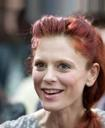
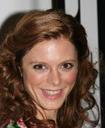
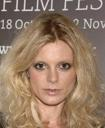
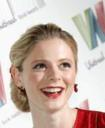
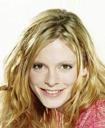
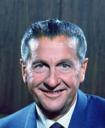
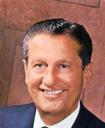
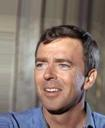
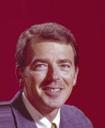
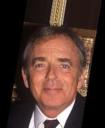

In [33]:
from domino.emb.bit import embed_images
embed_images.out().load()

In [18]:
from domino.evaluate import run_sdm
run_sdm(**run_sdm.inp())

task: run_sdm, run_id=22416
Creating slice discovery method...
Loading embeddings...


  0%|          | 0/1000 [00:00<?, ?it/s]

Fitting slice discovery method...


100%|██████████| 1000/1000 [00:19<00:00, 51.30it/s]


Transforming slice discovery method...
Explaining slices...


[Artifact(id=246550, run_id=22416, type=<class 'meerkat.datapanel.DataPanel'>),
 Artifact(id=246551, run_id=22416, type=<class 'meerkat.datapanel.DataPanel'>)]

In [15]:
run_sdm.inp()["data_dp"].load()["probs"]

,(TensorColumn)
0,torch.Tensor(shape=torch.Size([2]))
1,torch.Tensor(shape=torch.Size([2]))
2,torch.Tensor(shape=torch.Size([2]))
3,torch.Tensor(shape=torch.Size([2]))
4,torch.Tensor(shape=torch.Size([2]))
...,...
29994,torch.Tensor(shape=torch.Size([2]))
29995,torch.Tensor(shape=torch.Size([2]))
29996,torch.Tensor(shape=torch.Size([2]))
29997,torch.Tensor(shape=torch.Size([2]))


In [16]:
run_sdm.inp()["data_dp"].load()["target"]

,(NumpyArrayColumn)
0,0.0
1,1.0
2,1.0
3,1.0
4,0.0
...,...
29994,0.0
29995,1.0
29996,0.0
29997,0.0


In [27]:
run_sdm.inp()

{'data_dp': Artifact(id=231243, run_id=19395, type=<class 'meerkat.datapanel.DataPanel'>),
 'emb_dp': Artifact(id=231041, run_id=19192, type=<class 'meerkat.datapanel.DataPanel'>),
 'xmodal_emb_dp': Artifact(id=231045, run_id=19196, type=<class 'meerkat.datapanel.DataPanel'>),
 'model': None,
 'id_column': 'image_id',
 'word_dp': Artifact(id=225672, run_id=18284, type=<class 'meerkat.datapanel.DataPanel'>),
 'sdm_class': domino.sdm.spotlight.SpotlightSDM,
 'sdm_config': {'learning_rate': 0.001,
  'n_slices': 1,
  'emb': 'body',
  'xmodal_emb': 'emb'},
 'setting_id': 'e05cf483-a95d-4d8a-a0a0-6ce4e34937d0',
 'build_setting_run_id': Artifact(id=260736, run_id=24789, type=<class 'numpy.int64'>),
 'score_model_run_id': Artifact(id=260737, run_id=24789, type=<class 'numpy.int64'>),
 'score_settings_run_id': Artifact(id=260738, run_id=24789, type=<class 'numpy.int64'>),
 'synthetic_preds': Artifact(id=260739, run_id=24789, type=<class 'numpy.bool_'>),
 'index': '393',
 'alpha': 0.029999999999

In [28]:
"hel" in "hello"

True

In [31]:
terra.inp(25659)["sdm_class"]

domino.sdm.spotlight.SpotlightSDM

In [53]:
log = run_sdms.get_log()

In [50]:
log.find("end of loop")

167810

In [52]:
log[167810:]

"Retrying terra database commit (0/10).\n[2021-09-26 06:02:20.170960]: \x1b\x1b(ImplicitFunc pid=231)\x1b Retrying terra database commit (0/10).\n[2021-09-26 06:02:20.384720]: \x1b\x1b(ImplicitFunc pid=234)\x1b task: run_sdm, run_id=25890\n[2021-09-26 06:02:20.486869]: \x1b\x1b(ImplicitFunc pid=192)\x1b task: run_sdm, run_id=25923\n[2021-09-26 06:02:20.700582]: \x1b\x1b(ImplicitFunc pid=235)\x1b task: run_sdm, run_id=25887\n[2021-09-26 06:02:20.700678]: \x1b\x1b(ImplicitFunc pid=183)\x1b task: run_sdm, run_id=25922\n[2021-09-26 06:02:20.904203]: \x1b\x1b(ImplicitFunc pid=236)\x1b task: run_sdm, run_id=25881\n[2021-09-26 06:02:21.016377]: \x1b\x1b(ImplicitFunc pid=184)\x1b Retrying terra database commit (0/10).\n[2021-09-26 06:02:21.016460]: \x1b\x1b(ImplicitFunc pid=174)\x1b task: run_sdm, run_id=25905\n[2021-09-26 06:02:21.231271]: \x1b\x1b(ImplicitFunc pid=182)\x1b Retrying terra database commit (0/10).\n[2021-09-26 06:02:21.333166]: \x1b\x1b(ImplicitFunc pid=203)\x1b Retrying terra 